In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_excel('../data/barnstable_analysis_data.xlsx', 'data',index_col=0)
data["Excess Return"] = data["SPX"] - data["TB1M"]
data.dropna(inplace=True)

<AxesSubplot: xlabel='date'>

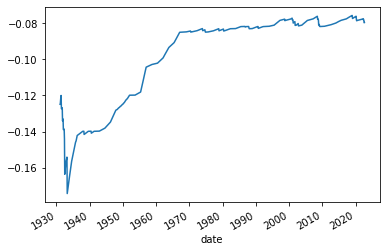

In [3]:
### Problem 1
### 1.1
### (a
data["Historic VaR"] = data["Excess Return"].expanding(min_periods = 60).quantile(0.05).shift(1)
data["Historic VaR"].plot()

In [4]:
### (b
Historic_VaR_frequency = round(len(data[data["Excess Return"]<data["Historic VaR"]])/len(data), 4)
Historic_VaR_frequency

0.0287

### (c
By definition of VaR, number instances of return should be less than VaR (5%) should be close to 5%, but in our case it is less than 3%.
So it seems that Historical VaR is not an unbiased estimation for the tail risk.

<AxesSubplot: xlabel='date'>

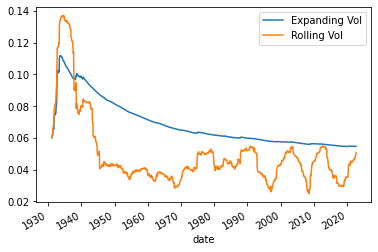

In [5]:
### 1.2
### a)
data["Expanding Vol"] = np.sqrt((data["Excess Return"]**2).expanding(min_periods = 60).mean().shift(1))
data["Rolling Vol"] = np.sqrt((data["Excess Return"]**2).rolling(window = 60).mean().shift(1))
data[["Expanding Vol","Rolling Vol"]].plot()

In [6]:
### b)
data["Expanding Vol_VaR"] = data["Expanding Vol"]*-1.65
data["Rolling Vol_VaR"] = data["Rolling Vol"]*-1.65

Historic_VaR_frequency:0.0287
Expanding_VaR_frequency:0.0166
Rolling_VaR_frequency:0.047


<AxesSubplot: xlabel='date'>

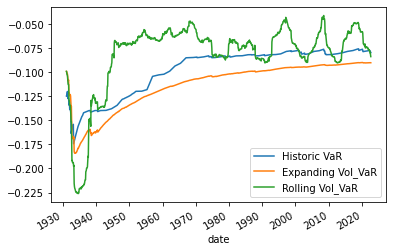

In [7]:
### c,d)
Expanding_VaR_frequency = round(len(data[data["Excess Return"]<data["Expanding Vol_VaR"]])/len(data), 4)
Rolling_VaR_frequency = round(len(data[data["Excess Return"]<data["Rolling Vol_VaR"]])/len(data), 4)
print("Historic_VaR_frequency:{}\nExpanding_VaR_frequency:{}\nRolling_VaR_frequency:{}".format(Historic_VaR_frequency,Expanding_VaR_frequency, Rolling_VaR_frequency))
data[["Historic VaR", "Expanding Vol_VaR","Rolling Vol_VaR"]].plot()

Historic_CVaR_frequency:0.0078
Expanding_CVaR_frequency:0.0671
Rolling_CVaR_frequency:0.1124


<AxesSubplot: xlabel='date'>

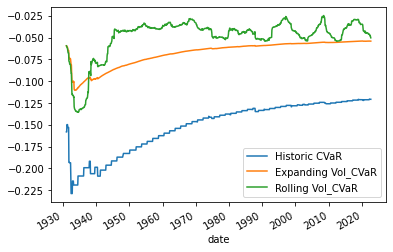

In [8]:
### 1.3
data["Historic CVaR"] = data["Excess Return"].expanding(min_periods = 60).apply(lambda x:x[x<x.quantile(0.05)].mean()).shift(1)

z_q = -1.65 
q = 0.05
coef_CVaR = -stats.norm().cdf(z_q)/q
data["Expanding Vol_CVaR"] = data["Expanding Vol"]*coef_CVaR
data["Rolling Vol_CVaR"] = data["Rolling Vol"]*coef_CVaR
Historic_CVaR_frequency = round(len(data[data["Excess Return"]<data["Historic CVaR"]])/len(data), 4)
Expanding_CVaR_frequency = round(len(data[data["Excess Return"]<data["Expanding Vol_CVaR"]])/len(data), 4)
Rolling_CVaR_frequency = round(len(data[data["Excess Return"]<data["Rolling Vol_CVaR"]])/len(data), 4)
print("Historic_CVaR_frequency:{}\nExpanding_CVaR_frequency:{}\nRolling_CVaR_frequency:{}".format(Historic_CVaR_frequency,Expanding_CVaR_frequency, Rolling_CVaR_frequency))
data[["Historic CVaR", "Expanding Vol_CVaR","Rolling Vol_CVaR"]].plot()

In [9]:
### 1.4
theta = 0.97
sigma_1 = 0.15
GARCH = arch_model(data['Excess Return'], vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
GARCH_params = GARCH_model.params
GARCH_params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38084950.95951727
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1909.9199599735189
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1909.9199630529993
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          0.007843
omega       0.000059
alpha[1]    0.100000
beta[1]     0.879999
Name: params, dtype: float64

In [10]:
data[["EWMA","GARCH"]]=None
data.loc[list(data.index)[0],["EWMA","GARCH"]] = sigma_1

In [11]:
for i in range(1, len(data)):
    data['EWMA'].iloc[i] = np.sqrt((data['EWMA'].iloc[i-1]**2) * theta \
                                    + (1-theta)*(data["Excess Return"].iloc[i-1]**2))
    data['GARCH'].iloc[i] = np.sqrt(GARCH_params['omega']\
                                     + (data['GARCH'].iloc[i-1]**2) * GARCH_params['beta[1]']\
                                     + GARCH_params['alpha[1]']*(data["Excess Return"].iloc[i-1]**2))

EWMA_VaR_frequency:0.0427
GARCH_VaR_frequency:0.0462
EWMA_CVaR_frequency:0.1124
GARCH_CVaR_frequency:0.1193


<AxesSubplot: xlabel='date'>

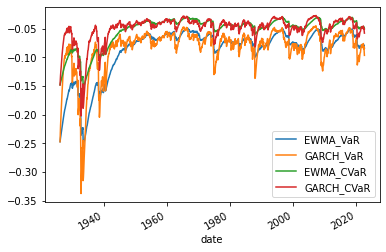

In [12]:
data["EWMA_VaR"] = data["EWMA"]*-1.65
data["GARCH_VaR"] = data["GARCH"]*-1.65
data["EWMA_CVaR"] = data["EWMA"]*coef_CVaR
data["GARCH_CVaR"] = data["GARCH"]*coef_CVaR
EWMA_VaR_frequency = round(len(data[data["Excess Return"]<data["EWMA_VaR"]])/len(data), 4)
GARCH_VaR_frequency = round(len(data[data["Excess Return"]<data["GARCH_VaR"]])/len(data), 4)
EWMA_CVaR_frequency = round(len(data[data["Excess Return"]<data["EWMA_CVaR"]])/len(data), 4)
GARCH_CVaR_frequency = round(len(data[data["Excess Return"]<data["GARCH_CVaR"]])/len(data), 4)
print("EWMA_VaR_frequency:{}\nGARCH_VaR_frequency:{}\nEWMA_CVaR_frequency:{}\nGARCH_CVaR_frequency:{}".format(EWMA_VaR_frequency,GARCH_VaR_frequency,EWMA_CVaR_frequency,GARCH_CVaR_frequency))
data[['EWMA_VaR', 'GARCH_VaR', 'EWMA_CVaR', 'GARCH_CVaR']].plot()

In [13]:
### Problem 3
### 3.1
### a)
level_data = pd.read_excel('../data/barnstable_analysis_data.xlsx', 'data',index_col=0)
level_data.dropna(inplace=True)
log_data = level_data.copy()
log_data = np.log(1+log_data)

In [14]:
def annualized_stats(data, annual_factor=12, log = False):
    if log == False:
        df = pd.DataFrame(data = None, 
                          index = ["market_return","excess_return","riskfree_return"])
    else: 
        df = pd.DataFrame(data = None, 
                      index = ["log_market_return","log_excess_return","log_riskfree_return"])
        
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + "_mean"] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()]
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + "_mean"] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + "_vol"] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()]
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + "_vol"] *= np.sqrt(annual_factor)
    
    return df

def res_join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

level_stats = res_join([annualized_stats(level_data.loc['1965':'1999']),
             annualized_stats(level_data.loc['2000':]),
             annualized_stats(level_data.loc['1926':])])

log_stats = res_join([annualized_stats(log_data.loc['1965':'1999'], log = True),
                 annualized_stats(log_data.loc['2000':], log = True),
                 annualized_stats(log_data.loc['1926':], log = True)])

stats_df = level_stats.append(log_stats)
stats_df

,1965-1999_mean,1965-1999_vol,2000-2022_mean,2000-2022_vol,1926-2022_mean,1926-2022_vol
market_return,0.130162,0.149507,0.075922,0.152555,0.113158,0.187785
excess_return,0.068659,0.150227,0.061608,0.153097,0.081621,0.188102
riskfree_return,0.061503,0.007179,0.014314,0.004978,0.031538,0.008573
log_market_return,0.118384,0.149675,0.064032,0.153660,0.095262,0.187076
log_excess_return,0.057064,0.150397,0.049739,0.154185,0.063803,0.187318
log_riskfree_return,0.061320,0.007132,0.014293,0.004968,0.031460,0.008539


### b)
The earlier subsample has much higher mean returns, but similar excess returns due to the notable decrease in riskfree return.

The log returns show lower mean returns as expected.

In [15]:
### 3.2
### a)
def underperform_prob(h,mu,sigma):
    res_df = pd.DataFrame(data=h,columns=['h'])
    res_df["underperform_prob"] = stats.norm.cdf(- np.sqrt(res_df["h"]) * mu / sigma)
    return res_df.set_index('h')
mu_1=stats_df.loc["log_excess_return","1965-1999_mean"]
sigma_1=stats_df.loc["log_excess_return","1965-1999_vol"]
underperform_prob(list(range(5,35,5)),mu_1,sigma_1)

,underperform_prob
h,
5,0.198103
10,0.115101
15,0.070849
20,0.044864
25,0.028906
30,0.018846


In [16]:
### b)
underperform_prob([15,30],mu_1,sigma_1)

,underperform_prob
h,
15,0.070849
30,0.018846


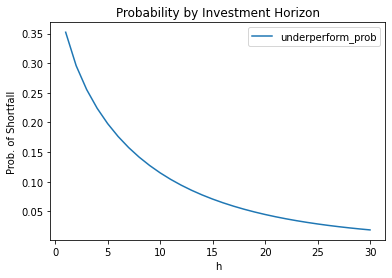

In [17]:
### c)
prob_horizon = underperform_prob(list(range(1,31)),mu_1,sigma_1)
prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

In [18]:
### 2.3
log_data_1965 = log_data.loc['1965':]
mu_2 = (log_data_1965['SPX'].mean()-log_data_1965['TB1M'].mean()) * 12
sigma_2 = (log_data_1965['SPX']-log_data_1965['TB1M']).std() * np.sqrt(12)
underperform_prob(list(range(5,35,5)),mu_2,sigma_2)

,underperform_prob
h,
5,0.212393
10,0.129502
15,0.083420
20,0.055212
25,0.037155
30,0.025289


In [19]:
### 2.4
### a)
mu_3 = stats_df.loc["log_market_return","1965-1999_mean"]-stats_df.loc["log_market_return","2000-2022_mean"]
underperform_prob([23],mu_3,sigma_1)

,underperform_prob
h,
23,0.041531


In [20]:
### b)
strike = np.log(1.06)
mu_4 = log_data_1965['SPX'].mean() * 12
sigma_4 = log_data_1965['SPX'].std() * np.sqrt(12)
mu = 23/7 * (stats_df.loc["log_market_return","2000-2022_mean"] - strike) + mu_4 - strike
underperform_prob([7], mu, sigma_4)

,underperform_prob
h,
7,0.15674
